## Estimação da Vida Útil Remanescente (RUL)

**Objetivo:** Prever a Vida Útil Remanescente (Remaining Useful Life - RUL) de um componente industrial, especificamente, quantos ciclos de operação ainda restam para um rolamento antes de uma provável falha.

**Contexto:** Em um ambiente industrial, rolamentos são componentes críticos cujo desgaste pode levar a paradas não planejadas e custos elevados. Monitorando sensores como **vibração** e **temperatura**, podemos identificar padrões de degradação e treinar um modelo de machine learning para estimar o RUL.

**Metodologia:** Utilizaremos **Modelos de Regressão** para mapear as leituras dos sensores ao RUL correspondente. Compararemos um modelo de baseline (Regressão Linear) com um modelo mais avançado (Random Forest Regressor).

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos e Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurações de visualização
plt.rcParams["figure.figsize"] = (15, 6)

### Geração de Dados Sintéticos

Como dados reais de degradação são difíceis de obter, vamos gerar um conjunto de dados sintético que simula o comportamento de múltiplos rolamentos ao longo de seus ciclos de vida.

**Premissas da Simulação:**
- Cada rolamento opera por um número variável de ciclos até a falha.
- A temperatura e a vibração aumentam à medida que o rolamento se aproxima do fim de sua vida útil.
- O aumento da vibração tende a ser exponencial perto da falha.

In [2]:
def generate_bearing_data(n_bearings=10, cycles_per_bearing_range=(150, 300)):
    """Gera dados de degradação para múltiplos rolamentos."""
    all_data = []
    for i in range(1, n_bearings + 1):
        # Define um tempo de vida aleatório para cada rolamento
        total_cycles = np.random.randint(*cycles_per_bearing_range)

        # Cria o array de ciclos e o RUL (alvo)
        cycles = np.arange(1, total_cycles + 1)
        rul = total_cycles - cycles

        # Simula os dados dos sensores
        # Temperatura: Aumenta linearmente com ruído
        temp_trend = 0.05 * (cycles / total_cycles)
        temp_noise = np.random.normal(0, 0.02, size=total_cycles)
        temperature = 60 + 15 * temp_trend + temp_noise * 5

        # Vibração: Aumenta exponencialmente com ruído
        vib_trend = np.exp(3.5 * (cycles / total_cycles))
        vib_noise = np.random.normal(0, 0.1, size=total_cycles)
        vibration = 0.1 + 0.05 * vib_trend + vib_noise

        # Cria um DataFrame para o rolamento atual
        bearing_df = pd.DataFrame(
            {
                "bearing_id": i,
                "cycle": cycles,
                "temperature": temperature,
                "vibration": vibration,
                "RUL": rul,
            }
        )
        all_data.append(bearing_df)

    return pd.concat(all_data).reset_index(drop=True)


# Gerando os dados
df = generate_bearing_data(n_bearings=50)

print("Amostra dos dados gerados (início da vida útil):")
print(df.head())
print("\nAmostra dos dados gerados (fim da vida útil):")
print(df.tail())

Amostra dos dados gerados (início da vida útil):
   bearing_id  cycle  temperature  vibration  RUL
0           1      1    60.117346   0.090153  283
1           1      2    60.063338   0.101312  282
2           1      3    59.905549   0.010673  281
3           1      4    60.099035   0.099413  280
4           1      5    59.941017   0.243050  279

Amostra dos dados gerados (fim da vida útil):
       bearing_id  cycle  temperature  vibration  RUL
11208          50    243    60.723043   1.612885    4
11209          50    244    60.730505   1.565328    3
11210          50    245    60.694994   1.709583    2
11211          50    246    60.842130   1.843932    1
11212          50    247    60.891520   1.714062    0


### Análise Exploratória de Dados (EDA)

Vamos visualizar a trajetória de degradação de um único rolamento para entender o comportamento dos dados.

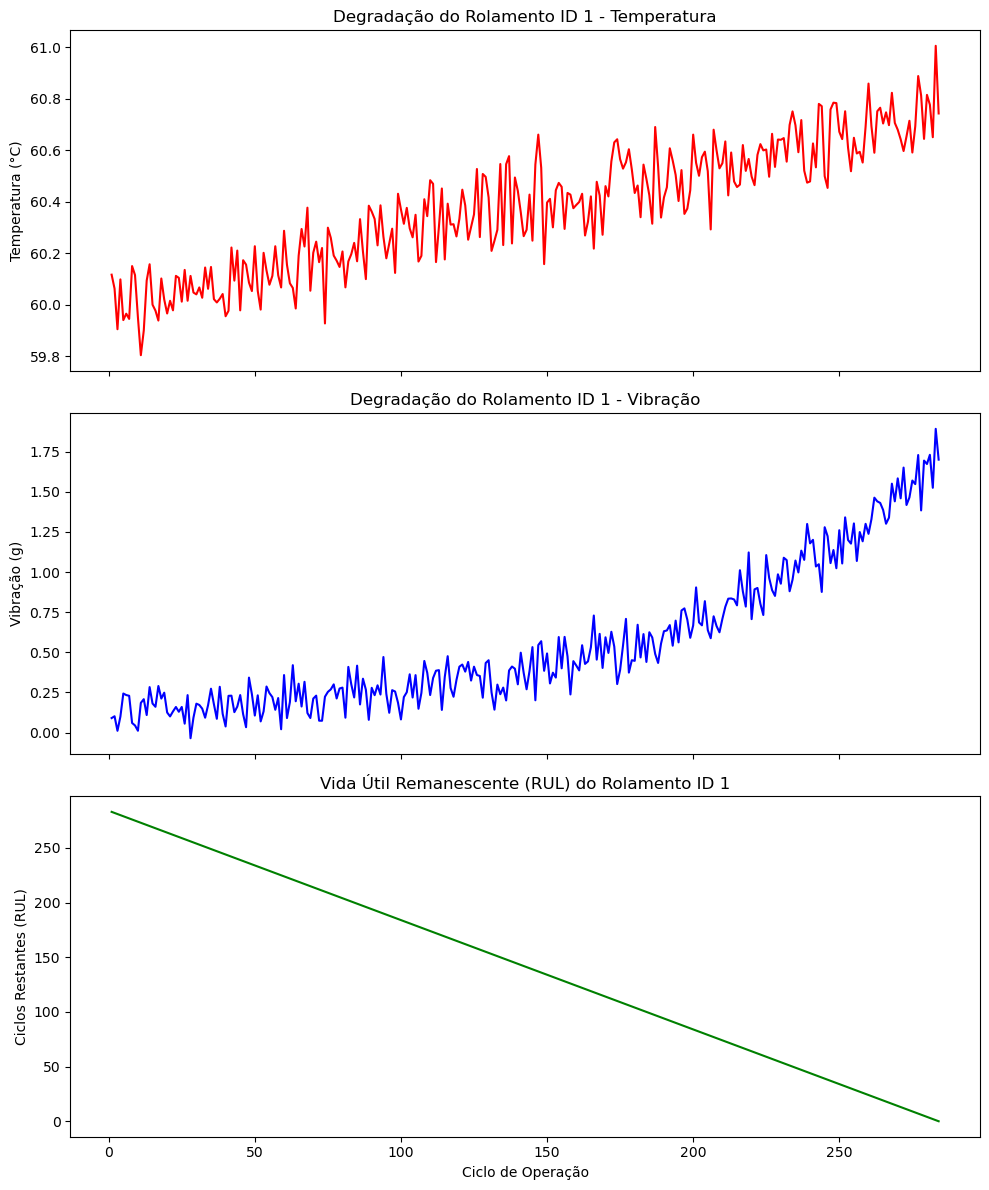

In [3]:
bearing_to_plot = df[df["bearing_id"] == 1]

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(bearing_to_plot["cycle"], bearing_to_plot["temperature"], color="red")
axs[0].set_title("Degradação do Rolamento ID 1 - Temperatura")
axs[0].set_ylabel("Temperatura (°C)")

axs[1].plot(bearing_to_plot["cycle"], bearing_to_plot["vibration"], color="blue")
axs[1].set_title("Degradação do Rolamento ID 1 - Vibração")
axs[1].set_ylabel("Vibração (g)")

axs[2].plot(bearing_to_plot["cycle"], bearing_to_plot["RUL"], color="green")
axs[2].set_title("Vida Útil Remanescente (RUL) do Rolamento ID 1")
axs[2].set_ylabel("Ciclos Restantes (RUL)")
axs[2].set_xlabel("Ciclo de Operação")

plt.tight_layout()

### Engenharia de Features (Feature Engineering)

Os dados brutos dos sensores podem ser ruidosos. Para capturar melhor as tendências de degradação, vamos criar features baseadas em janelas móveis (rolling windows), como média e desvio padrão.

- **Média Móvel:** Suaviza o ruído e captura a tendência central.
- **Desvio Padrão Móvel:** Captura a volatilidade ou instabilidade, que geralmente aumenta antes da falha.

In [4]:
window_size = 15

# Média móvel
df["temp_mov_avg"] = (
    df.groupby("bearing_id")["temperature"]
    .rolling(window=window_size)
    .mean()
    .reset_index(0, drop=True)
)
df["vib_mov_avg"] = (
    df.groupby("bearing_id")["vibration"]
    .rolling(window=window_size)
    .mean()
    .reset_index(0, drop=True)
)

# Desvio padrão móvel
df["temp_mov_std"] = (
    df.groupby("bearing_id")["temperature"]
    .rolling(window=window_size)
    .std()
    .reset_index(0, drop=True)
)
df["vib_mov_std"] = (
    df.groupby("bearing_id")["vibration"]
    .rolling(window=window_size)
    .std()
    .reset_index(0, drop=True)
)

# Remove os valores NaN criados pela janela móvel no início de cada série
df_featured = df.dropna().reset_index(drop=True)

print("Dados após engenharia de features:")
df_featured.head()

Dados após engenharia de features:


,bearing_id,cycle,temperature,vibration,RUL,temp_mov_avg,vib_mov_avg,temp_mov_std,vib_mov_std
0,1,15,60.000722,0.180640,269,60.014279,0.139128,0.107387,0.089302
1,1,16,59.977742,0.160360,268,60.004972,0.143808,0.103806,0.088387
2,1,17,59.939164,0.290000,267,59.996693,0.156388,0.103770,0.095080
3,1,18,60.102500,0.211650,266,60.009823,0.169786,0.103874,0.086887
4,1,19,60.020768,0.248306,265,60.004606,0.179712,0.100999,0.086778


### Preparação dos Dados para Modelagem

Vamos dividir nosso conjunto de dados em features (X) e alvo (y), e depois em conjuntos de treino e teste.

In [5]:
# Selecionando as features e o alvo
features = [
    "temperature",
    "vibration",
    "temp_mov_avg",
    "vib_mov_avg",
    "temp_mov_std",
    "vib_mov_std",
]
target = "RUL"

X = df_featured[features]
y = df_featured[target]

# Divisão em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treino: 8410 amostras
Tamanho do conjunto de teste: 2103 amostras


### Treinamento e Avaliação dos Modelos

Vamos treinar e avaliar dois modelos de regressão.

In [6]:
# Dicionário para armazenar os modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
}

results = {}

for name, model in models.items():
    # Treinamento
    model.fit(X_train, y_train)

    # Previsão
    y_pred = model.predict(X_test)

    # Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"pred": y_pred, "mae": mae, "rmse": rmse, "r2": r2}

    print(f"--- Resultados para {name} ---")
    print(f"MAE (Erro Médio Absoluto): {mae:.2f} ciclos")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f} ciclos")
    print(f"R² Score: {r2:.4f}")
    print("\n")

--- Resultados para Linear Regression ---
MAE (Erro Médio Absoluto): 19.79 ciclos
RMSE (Raiz do Erro Quadrático Médio): 25.50 ciclos
R² Score: 0.8596


--- Resultados para Random Forest Regressor ---
MAE (Erro Médio Absoluto): 15.83 ciclos
RMSE (Raiz do Erro Quadrático Médio): 21.89 ciclos
R² Score: 0.8965




#### Visualização das Previsões versus Valores Reais

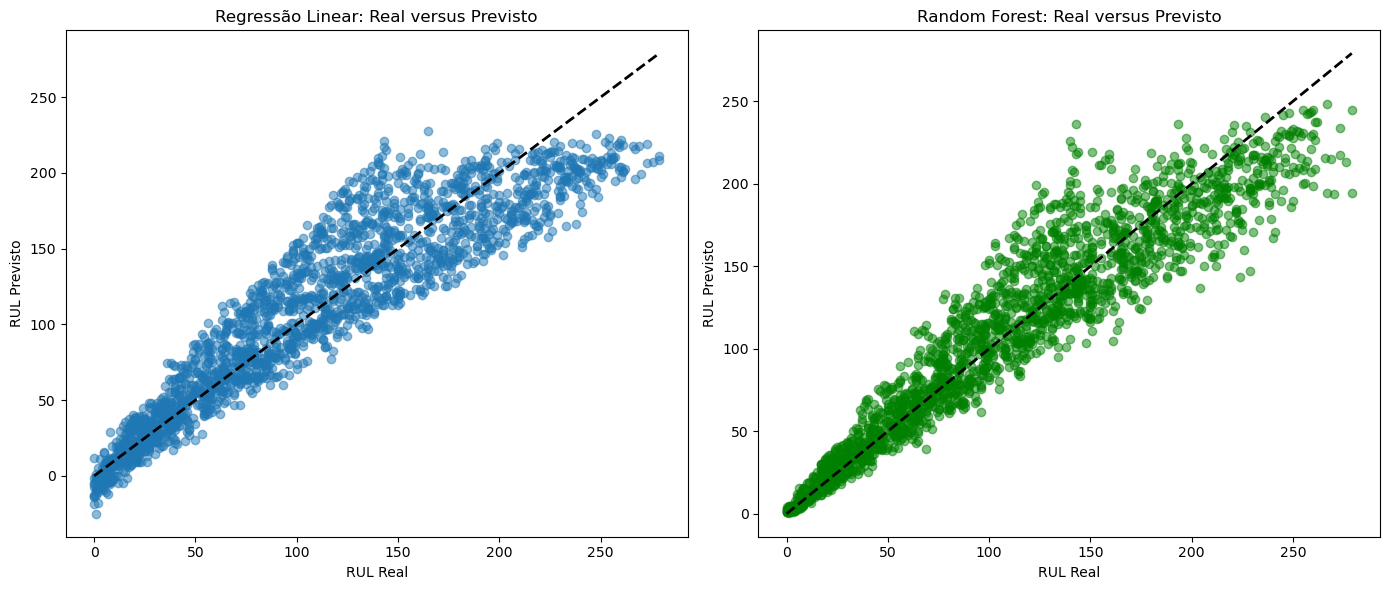

In [7]:
plt.figure(figsize=(14, 6))

# Gráfico para Regressão Linear
plt.subplot(1, 2, 1)
plt.scatter(y_test, results["Linear Regression"]["pred"], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.title("Regressão Linear: Real versus Previsto")
plt.xlabel("RUL Real")
plt.ylabel("RUL Previsto")

# Gráfico para Random Forest
plt.subplot(1, 2, 2)
plt.scatter(
    y_test, results["Random Forest Regressor"]["pred"], alpha=0.5, color="green"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.title("Random Forest: Real versus Previsto")
plt.xlabel("RUL Real")
plt.ylabel("RUL Previsto")

plt.tight_layout()

**Análise dos Gráficos:** A linha tracejada representa a "previsão perfeita" (onde o valor real é igual ao previsto). O Random Forest Regressor mostra pontos muito mais próximos dessa linha, indicando um desempenho superior.

### Análise de Importância das Features

Uma grande vantagem de modelos como o Random Forest é a capacidade de avaliar a importância de cada feature para a previsão. Isso nos ajuda a entender quais sensores e quais características são mais informativos.

/tmp/ipykernel_29278/966233665.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feature_importance, palette="viridis")


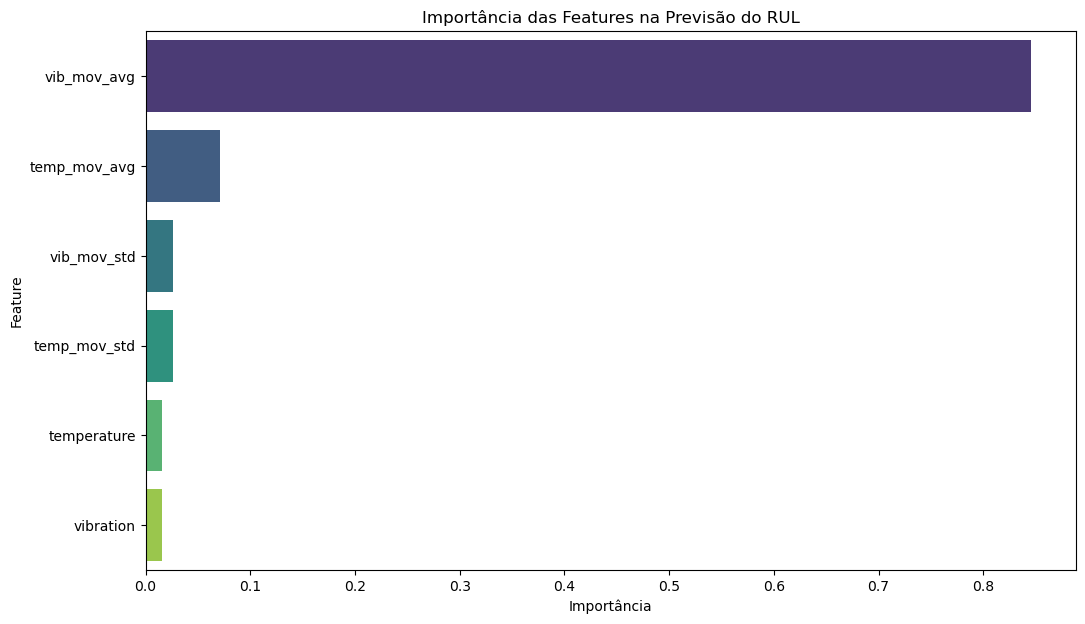

In [8]:
# Extrai o modelo treinado
rf_model = models["Random Forest Regressor"]

# Cria um DataFrame com as importâncias
feature_importance = pd.DataFrame(
    {"feature": features, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

# Plota o gráfico de barras
plt.figure(figsize=(12, 7))
sns.barplot(x="importance", y="feature", data=feature_importance, palette="viridis")
plt.title("Importância das Features na Previsão do RUL")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()

**Análise da Importância:**
O gráfico provavelmente mostrará que as **features de janela móvel (especialmente o desvio padrão da vibração)** são mais importantes que os dados brutos. Isso confirma que a **instabilidade** do sinal (`vib_mov_std`) é um forte indicador de que o rolamento está se aproximando da falha.

### Conclusão

Neste notebook, construímos um pipeline completo para estimar a Vida Útil Remanescente (RUL) de rolamentos com base em dados de sensores.

1.  **Geração de Dados:** Criamos um dataset sintético que simula a degradação real de componentes.
2.  **Engenharia de Features:** Demonstramos que a criação de features como médias e desvios padrão móveis melhora significativamente o desempenho do modelo.
3.  **Modelagem:** O `Random Forest Regressor` superou drasticamente a `Regressão Linear`, mostrando sua capacidade de capturar as relações não-lineares complexas presentes nos dados de degradação.
4.  **Interpretabilidade:** A análise de importância das features nos deu insights valiosos, destacando a instabilidade da vibração como o principal preditor do RUL.

**Impacto Prático:** Um modelo como este permite que as equipes de manutenção ajam de forma proativa, substituindo componentes pouco antes da falha. Isso leva à **redução de custos** (evitando falhas catastróficas e paradas não planejadas) e ao **aumento da segurança e eficiência** operacional.